# Qctrl optimization of pulse with finite blockade strength and nonzero NNN interactions
## Updated Hamiltonian
## optimization over:
### - phase
### - atom distance
### - Blockade interaction distance decay exponent
### - duration  
### - TODO: explore different pulse shapes or constant detuning/phase/amplitude, try gaussian pulses

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import boulderopal as bo
import pickle


plt.style.use(qv.get_qctrl_style())
controls_for_plots = lambda opt: {
    '$\\Delta$': opt['output']['delta'],
    '$\\Omega$': opt['output']['omega'],
    '$\\Phi$': opt['output']['phi']
}

Boulder Opal client update available.
Latest version is 1.4.0, you have 1.3.2.
Visit https://docs.q-ctrl.com/boulder-opal/changelog for the latest product updates.


In [2]:
# Dictionary for 27x27 Hamiltonian indexing
Hidx27 ={}
Hidx27['000'] = 0
Hidx27['100'] = 1
Hidx27['r00'] = 2
Hidx27['001'] = 3
Hidx27['00r'] = 4
Hidx27['101'] = 5
Hidx27['r01'] = 6
Hidx27['10r'] = 7
Hidx27['r0r'] = 8
Hidx27['010'] = 9
Hidx27['0r0'] = 10
Hidx27['110'] = 11
Hidx27['1r0'] = 12
Hidx27['r10'] = 13
Hidx27['rr0'] = 14
Hidx27['011'] = 15
Hidx27['0r1'] = 16
Hidx27['01r'] = 17
Hidx27['0rr'] = 18
Hidx27['111'] = 19
Hidx27['1r1'] = 20
Hidx27['r11'] = 21
Hidx27['11r'] = 22
Hidx27['r1r'] = 23
Hidx27['rr1'] = 24
Hidx27['1rr'] = 25
Hidx27['rrr'] = 26


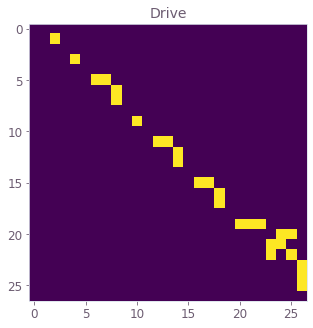

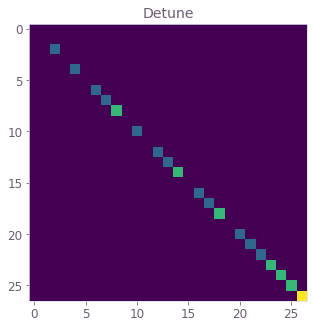

In [3]:
# Components for the drive operator.
drive_operator = np.zeros((27, 27))
# Components for the detuning operator.
detuneDiag = np.zeros(27)

# All A* terms handled by hermitian_part call later and not encoded here
# Blockade interactions in cells below
# Hamiltonian Term Breakdown
# —-------------
# 000 :	0

# 100 :	A  |r00> <100|
drive_operator[Hidx27['100'], Hidx27['r00']] = 1

# r00 :	A*  |100> <r00|     +   Δ  |r00> <r00|
detuneDiag[Hidx27['r00']] = 1

# 001 :	A   |00r> <001|
drive_operator[Hidx27['001'], Hidx27['00r']] = 1

# 00r :	A*   |001> <00r|  +   Δ  |00r> <00r|
detuneDiag[Hidx27['00r']] = 1

# 101 :	A   |r01> <101| + A   |10r> <101| 
drive_operator[Hidx27['101'], Hidx27['r01']] = 1
drive_operator[Hidx27['101'], Hidx27['10r']] = 1

# r01 :	A  |r0r> <r01| + A*  |101> <r01| +   Δ  |r01> <r01|
drive_operator[Hidx27['r01'], Hidx27['r0r']] = 1
detuneDiag[Hidx27['r01']] = 1

# 10r :	A  |r0r> <10r| + A*  |101> <10r|  +   Δ  |10r> <10r|
drive_operator[Hidx27['10r'], Hidx27['r0r']] = 1
detuneDiag[Hidx27['10r']] = 1

# r0r :	A*  |r01> <r0r| + A* |10r> <r0r|  +   (2 Δ  + V (2d) -ɑ ) |r0r> <r0r|
detuneDiag[Hidx27['r0r']] = 2

# —-----------------------------------
# 010 :	A   |0r0> <010|
drive_operator[Hidx27['010'], Hidx27['0r0']] = 1

# 0r0 :	A*   |010> <0r0|    +   Δ   |0r0> <0r0|
detuneDiag[Hidx27['0r0']] = 1

# 110 :	A   |r10> <110| + A  |1r0> <110|  
drive_operator[Hidx27['110'], Hidx27['r10']] = 1
drive_operator[Hidx27['110'], Hidx27['1r0']] = 1

# 1r0 :	A   |rr0> <1r0| + A*  |110> <1r0|     +   Δ  |1r0> <1r0|
drive_operator[Hidx27['1r0'], Hidx27['rr0']] = 1
detuneDiag[Hidx27['1r0']] = 1

# r10 :	A   |rr0> <r10| + A* |110> <r10|     +   Δ  |r10> <r10|
drive_operator[Hidx27['r10'], Hidx27['rr0']] = 1
detuneDiag[Hidx27['r10']] = 1

# rr0 :	A*  |1r0> <rr0| + A* |r10> <rr0|  +   (2 Δ  + V (d) -ɑ )  |rr0> <rr0| 
detuneDiag[Hidx27['rr0']] = 2

# 011 :	A  |0r1> <011| + A |01r> <011|
drive_operator[Hidx27['011'], Hidx27['0r1']] = 1
drive_operator[Hidx27['011'], Hidx27['01r']] = 1

# 0r1 :	A   |0rr> <0r1| + A*  |011> <0r1|    +   Δ   |0r1> <0r1|
drive_operator[Hidx27['0r1'], Hidx27['0rr']] = 1
detuneDiag[Hidx27['0r1']] = 1

# 01r :	A   |0rr> <01r| + A*  |011> <01r|     +   Δ   |01r><01r|
drive_operator[Hidx27['01r'], Hidx27['0rr']] = 1
detuneDiag[Hidx27['01r']] = 1

# 0rr :	A*  |0r1> <0rr| + A* |01r> <0rr|  +   (2 Δ  + V (d) -ɑ )  |0rr><0rr| 
detuneDiag[Hidx27['0rr']] = 2

# —----------------------------------
# 111 :	A |r11> <111| + A  |1r1> <111| + A  |11r> <111|
drive_operator[Hidx27['111'], Hidx27['r11']] = 1
drive_operator[Hidx27['111'], Hidx27['1r1']] = 1
drive_operator[Hidx27['111'], Hidx27['11r']] = 1

# 1r1 :	A   |rr1> <1r1| + A   |1rr> <1r1| + A*   |111> <1r1| +   Δ  |1r1> <1r1|
drive_operator[Hidx27['1r1'], Hidx27['rr1']] = 1
drive_operator[Hidx27['1r1'], Hidx27['1rr']] = 1
detuneDiag[Hidx27['1r1']] = 1

# r11 :	A   |rr1> <r11| + A   |r1r> <r11| + A*   |111> <r11| +   Δ  |r11> <r11|
drive_operator[Hidx27['r11'], Hidx27['rr1']] = 1
drive_operator[Hidx27['r11'], Hidx27['r1r']] = 1
detuneDiag[Hidx27['r11']] = 1

# 11r :	A   |r1r> <11r| + A   |1rr> <11r| + A*   |111> <11r| +   Δ  |11r> <11r|
drive_operator[Hidx27['11r'], Hidx27['r1r']] = 1
drive_operator[Hidx27['11r'], Hidx27['1rr']] = 1
detuneDiag[Hidx27['11r']] = 1

# r1r :	A   |rrr> <r1r| + A*  |11r> <r1r| + A*  |r11> <r1r| + (2 Δ  + V (2d) -ɑ ) |r1r> <r1r|
drive_operator[Hidx27['r1r'], Hidx27['rrr']] = 1
detuneDiag[Hidx27['r1r']] = 2

# rr1  :	A   |rrr> <rr1| + A*  |1r1> <rr1| + A*  |r11> <rr1| + (2 Δ  + V (d) -ɑ ) |rr1|><rr1|
drive_operator[Hidx27['rr1'], Hidx27['rrr']] = 1
detuneDiag[Hidx27['rr1']] = 2

# 1rr  :	A   |rrr> <1rr| + A*  |11r> <1rr| + A*  |1r1> <1rr| + (2 Δ  + V (d) -ɑ ) |1rr> <1rr|
drive_operator[Hidx27['1rr'], Hidx27['rrr']] = 1
detuneDiag[Hidx27['1rr']] = 2

# rrr :	 A*  |r1r> <rrr| +  A*  |rr1> <rrr| +  A*  |1rr> <rrr| + 
# (3 Δ  + V ((2d) -ɑ +2 (d) -ɑ)) |rrr><rrr| 
detuneDiag[Hidx27['rrr']] = 3



detuning_operator = np.diag(detuneDiag)

plt.imshow(drive_operator)
plt.title("Drive")
plt.show()
plt.imshow(detuning_operator)
plt.title("Detune")
plt.show()

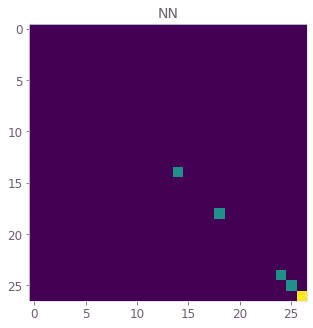

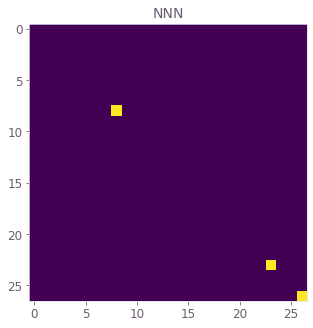

In [4]:
# Set parameters.
omega_max = 5 * 2 * np.pi * 1e6 # rad/s
delta_max = omega_max

# Components for the CCZ operator.
cz_0 = np.zeros(27)
cz_0[0] = 1
cz_0 = np.diag(cz_0)

cz_1 = np.zeros(27)
cz_1[[Hidx27['100'],Hidx27['010'],Hidx27['001']]] = 1
cz_1 = np.diag(cz_1)

cz_11 = np.zeros(27)
cz_11[[Hidx27['110'],Hidx27['101'],Hidx27['011']]] = 1
cz_11 = np.diag(cz_11)

cz_111 = np.zeros(27)
cz_111[Hidx27['111']] = 1
cz_111 = np.diag(cz_111)

# Blockade interactions

Blockade = 50 * 2 * np.pi * 1e9 # 50 GHz * µm^6

# next nearest neighbor
blockN3 = np.zeros(27)
blockN3[[Hidx27['r0r'],Hidx27['r1r'],Hidx27['rrr']]] = Blockade
blockN3 = np.diag(blockN3)

# nearest neighbor
blockNN = np.zeros(27)
blockNN[[Hidx27['0rr'],Hidx27['1rr'],Hidx27['rr0'],Hidx27['rr1']]] = Blockade
blockNN[Hidx27['rrr']] = 2*Blockade
blockNN = np.diag(blockNN)
plt.imshow(blockNN)
plt.title("NN")
plt.show()
plt.imshow(blockN3)
plt.title("NNN")
plt.show()

In [5]:
tau =  1 # * 1e-6 # s  *** use 1 when optimizing duration
max_duration=5e-6 # 5 us
# Define the control.
segment_countz = [50,50,50] #drive, detune, rabi
smoothing = [False,False,False]  #drive, detune, rabi
sample_times = np.linspace(0, tau, 200)



graph = bo.Graph()

duration = graph.optimizable_scalar(lower_bound = 1e-9, upper_bound = max_duration)
duration.name = "duration"



# Real piece-wise constant signal representing the Rabi phase.
uphi = (
    graph.real_optimizable_pwc_signal(
        segment_count = segment_countz[2], 
        duration = tau, 
        minimum = 0,
        maximum = 2 * np.pi, 
        name = 'uphi'
    )
)



fphi = graph.filter_and_resample_pwc(
    pwc=uphi,
    #kernel=graph.sinc_convolution_kernel(2 * np.pi * max_duration/2),
    kernel=graph.sinc_convolution_kernel(omega_max * max_duration/2),
    segment_count=segment_countz[2],
    name="fphi",
)


env_phi = graph.signals.cosine_pulse_pwc(
    duration=tau, segment_count=segment_countz[2], amplitude=1.0
)

if smoothing[2]:
    phi = env_phi * fphi
else:
    phi = uphi
phi.name = "phi"

   
amp = graph.optimizable_scalar(
    lower_bound = 1,
    upper_bound = omega_max, 
    name = 'amplitudeOmega')

omega = graph.signals.gaussian_pulse_pwc(
duration=1,
segment_count=segment_countz[0], 
amplitude=amp, 
center_time=None,
flat_duration=.95,
segmentation = 'MINIMAL',
name='omega')

amp2 = graph.optimizable_scalar(
    lower_bound = 1,
    upper_bound = omega_max, 
    name = 'amplitudeDelta')

delta = graph.signals.gaussian_pulse_pwc(
duration=1,
segment_count=segment_countz[1], 
amplitude=amp2, 
center_time=None,
flat_duration=.95,
segmentation = 'MINIMAL',
name='delta')


# Real scalar signal representing the single qubit phase.
psi = (
    graph.optimizable_scalar(
        lower_bound = 0,
        upper_bound = 2 * np.pi, 
        name = 'psi'
    )
)


#atom distance (um)
r = (
    graph.optimizable_scalar(
        lower_bound = 3,
        upper_bound = 6, 
        name = 'r'
    )
)

#exponent
alpha = (
    graph.optimizable_scalar(
        lower_bound = 3,
        upper_bound = 6, 
        name = 'alpha'
    )
)


# Define the Hamiltonian.
hamiltonian = (
    graph.hermitian_part(omega * graph.exp(1j * phi) * drive_operator) + 
    delta * detuning_operator + r**(-alpha)*(blockNN+blockN3/(2**alpha))
) * duration


# Define the target operator.
target = (
    graph.target(
        operator = (cz_0 +
            graph.exp(1j * psi) * cz_1 + 
            graph.exp(1j * 2 * psi) * cz_11 + 
            graph.exp(1j * (3 * psi + np.pi)) * cz_111
        )
    )
)

# Unitary time evolution.
unitary = (
    graph.time_evolution_operators_pwc(
        hamiltonian = hamiltonian, 
        sample_times = sample_times, 
        name = 'unitary'
    )
)

# Infidelity.
infidelity = (
    graph.infidelity_pwc(
        hamiltonian = hamiltonian,
        target = target,
        name = 'infidelity'
    )
)

# Cost function.
cost_function = (
    graph.sum(
        infidelity
    )
)
cost_function.name = 'cost_function'

In [ ]:
 result = (
    bo.run_optimization(
        graph = graph,
        cost_node_name = 'cost_function',
        output_node_names = [
            'omega', 
            'delta', 
            'phi', 
            'psi', 
            'unitary',
            'infidelity'
            ,'r'
            ,'duration'
            ,'alpha'
            ,'amplitudeOmega'
            ,'amplitudeDelta'
        ]
    )
 )

Your task (action_id="1996630") is queued.


In [ ]:
eta = result['output']['delta']['values'][0] / result['output']['omega']['values'][0]
#xi = np.abs(result['output']['phi']['values'][0] - result['output']['phi']['values'][1])
omegatau = result['output']['omega']['values'][0] * tau / 2

print(f"Infidelity: {result['output']['infidelity']['value']:.3e}")
print(f"Gate time: {omegatau}")
print(f"Ratio of detuning and Rabi frequncy: {eta}")
#print(f"Phase jump: {xi}")
#print(f"Equivalent phase jump: {2 * np.pi - xi}")
print(f"Single qubit phase: {result['output']['psi']['value']}")
print(f"Radius: {result['output']['r']['value']}")
print(f"Duration: {result['output']['duration']['value']}")
print(f"Exponent: {result['output']['alpha']['value']}")

In [ ]:
qv.plot_controls(controls_for_plots(result))

In [ ]:
u = result['output']['unitary']['value']
psi0 = np.zeros(27)
psi0[Hidx27['000']] = 1
out0 = np.abs(np.transpose(psi0) @ u @ psi0)**2
psi1 = np.zeros(27)
psi1[Hidx27['100']] = 1
out1 = np.abs(np.transpose(psi1) @ u @ psi1)**2
psi11 = np.zeros(27)
psi11[Hidx27['101']] = 1
out11 = np.abs(np.transpose(psi11) @ u @ psi11)**2
psi111 = np.zeros(27)
psi111[Hidx27['111']] = 1
out111 = np.abs(np.transpose(psi111) @ u @ psi111)**2
plt.plot(1e9 * sample_times, out0)
plt.plot(1e9 * sample_times, out1)
plt.plot(1e9 * sample_times, out11)
plt.plot(1e9 * sample_times, out111)
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.legend(['|0>','|1>','|11>','|111>'])

In [6]:
dataz = {}
for i in range(500):
    print('-------- Starting Trial #' + str(i) + ' --------')
    result = (
    bo.run_optimization(
        graph = graph,
        cost_node_name = 'cost_function',
        output_node_names = [
            'omega', 
            'delta', 
            'phi', 
            'psi', 
            'unitary',
            'infidelity'
            ,'r'
            ,'duration'
            ,'alpha'
            ,'amplitudeOmega'
            ,'amplitudeDelta'
        ]))
    infidelity = result['output']['infidelity']['value']
    if infidelity < 1e-5:
        dataz['trial'+str(i)] = [dict(result)['output']['infidelity']['value'],dict(result)]
with open('Rabi50_resultz2.pickle', 'wb') as handle:
    pickle.dump(dataz, handle, protocol=pickle.HIGHEST_PROTOCOL)


-------- Starting Trial #0 --------
Your task (action_id="1996631") is queued.
Your task (action_id="1996631") has started.
Your task (action_id="1996631") has completed.
-------- Starting Trial #1 --------
Your task (action_id="1996632") has started.
Your task (action_id="1996632") has completed.
-------- Starting Trial #2 --------
Your task (action_id="1996633") has started.
Your task (action_id="1996633") has completed.
-------- Starting Trial #3 --------
Your task (action_id="1996634") has started.
Your task (action_id="1996634") has completed.
-------- Starting Trial #4 --------
Your task (action_id="1996635") has started.
Your task (action_id="1996635") has completed.
-------- Starting Trial #5 --------
Your task (action_id="1996636") has started.
Your task (action_id="1996636") has completed.
-------- Starting Trial #6 --------
Your task (action_id="1996637") is queued.
Your task (action_id="1996637") has started.
Your task (action_id="1996637") has completed.
-------- Starting 

ReadTimeout: HTTPSConnectionPool(host='federation-service.q-ctrl.com', port=443): Read timed out. (read timeout=None)

In [ ]:
with open('Rabi50_resultz.pickle', 'rb') as handle:
    b = pickle.load(handle)


In [ ]:
for i in b:
    print(b[i][0])

In [50]:
infz = []
for i in dataz:
    infz.append(dataz[i][0])
min(infz)

1.389549727504047e-07